In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from helper_functions.load_data import load_data
from sklearn import set_config
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    accuracy_score,
    balanced_accuracy_score,
    roc_curve,
    roc_auc_score,
    RocCurveDisplay,
    f1_score,
    classification_report,
)

#### Read in data

We start out with a simple model in which we just use the passengers' cabin class to predict the likelihood of survival of the passengers.

Loading in train.csv...
Data set successfully loaded.



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


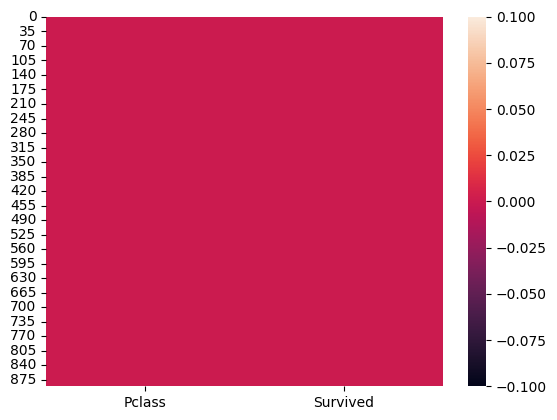

In [2]:
titanic = load_data(
    "train.csv",
    "https://spiced.space/regularised-aniseed/ds-course/_downloads/6df11ef5f535b97c47efc5873d018bf1/train.csv",
    sep=",",
)
sns.heatmap(titanic[["Pclass", "Survived"]].isna())
titanic.head()


In [3]:
titanic["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [4]:
titanic["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

No cleaning necessary and class imbalances do exist but aren't that bad.

#### Build model pipeline

In [5]:
# Define features
categorical_features = ["Pclass"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="first")

# Build preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("categoric", categorical_transformer, categorical_features),
    ]
)

# Build pipeline
pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            LogisticRegression(C=1e5, class_weight="balanced", random_state=42),
        ),
    ]
)
pipe


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categoric',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Pclass'])])),
                ('classifier',
                 LogisticRegression(C=100000.0, class_weight='balanced',
                                    random_state=42))])

#### Train-test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    titanic[["Pclass"]],
    titanic["Survived"],
    test_size=0.2,
    random_state=42,
)

#### Train the model

In [7]:
pipe.fit(X_train, y_train)
print(f"The model's coefficients are {pipe.named_steps['classifier'].coef_[0]} and its intercept is {pipe.named_steps['classifier'].intercept_[0]:.5}.")

The model's coefficients are [-0.50248587 -1.58231447] and its intercept is 0.94107.


#### Predict and evaluate

In [8]:
print(classification_report(y_true=y_test, y_pred=pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.67      0.71       105
           1       0.59      0.69      0.64        74

    accuracy                           0.68       179
   macro avg       0.67      0.68      0.67       179
weighted avg       0.69      0.68      0.68       179



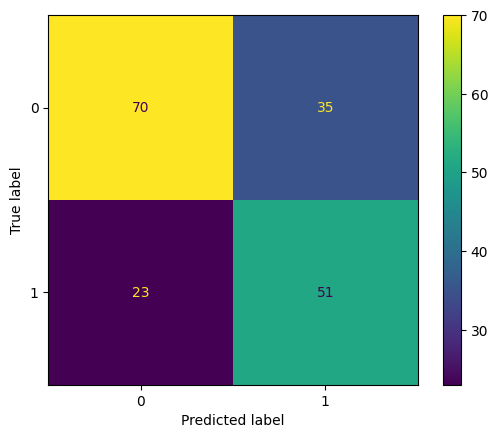

In [9]:
# Confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, pipe.predict(X_test), normalize=None
)

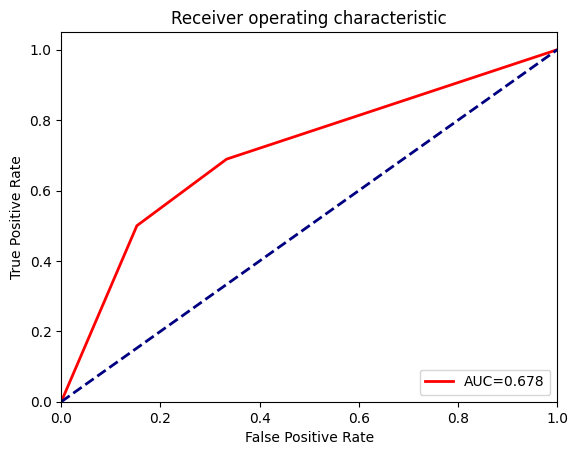

In [10]:
fpr, tpr, threshold = roc_curve(y_test, pipe.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test, pipe.predict(X_test))
# Plot ROC
fig, ax = plt.subplots()
lw = 2
ax.plot(
    fpr, tpr,
    lw=lw,
    label=f"AUC={roc_auc:.3f}",
    color="red",
)
ax.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

Out of the box, the performance of a simple model, only using passenger class without any transformation, is not great in predicting the passengers' survival. We should do some feature selection and engineering to improve performance.

#### Feature engineering

We will now add additional features namely the passengers' sex, their age, how much they paid for the ticket (fare), the location of the cabin relative to the ship's deck, the size of their family and whether they actuall embarked on the ship.

In [11]:
df_to_analyze = titanic.drop(["Name", "PassengerId"], axis=1)
df_to_analyze.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
df_to_analyze.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


<AxesSubplot: >

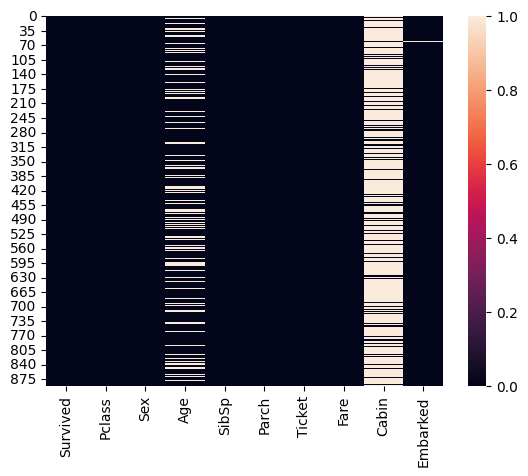

In [13]:
sns.heatmap(df_to_analyze.isna())

In [14]:
sum(df_to_analyze["Fare"].isna())

0

In [15]:
# We impute the missing values for age with averages
df_to_analyze["Age"] = df_to_analyze["Age"].fillna(df_to_analyze["Age"].mean())

In [16]:
# Let's inspect the cabin ids
df_to_analyze['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [17]:
# To get the location of the cabin relative to the deck, we will only need the first letter of the cabin identifier
df_to_analyze['Deck'] = df_to_analyze['Cabin'].str[0]
df_to_analyze = df_to_analyze.drop(['Cabin'], axis=1)
# Passengers without a cabin Id will be ignored for one-hot encoding but it is good practice to impute the value with something we know.
# So substitute unknown cabins with NA:
df_to_analyze["Deck"].fillna("NA", inplace=True)
df_to_analyze.value_counts()

Survived  Pclass  Sex     Age        SibSp  Parch  Ticket    Fare     Embarked  Deck
0         3       male    29.699118  8      2      CA. 2343  69.5500  S         NA      4
                  female  29.699118  3      1      4133      25.4667  S         NA      3
                                     8      2      CA. 2343  69.5500  S         NA      3
          2       male    29.699118  0      0      239853    0.0000   S         NA      3
1         3       male    29.699118  1      1      2661      15.2458  C         NA      2
                                                                                       ..
0         3       male    20.000000  0      0      347466    7.8542   S         NA      1
                                                   350050    7.8542   S         NA      1
                                                   6563      9.2250   S         NA      1
                                                   7534      9.8458   S         NA      1
1         3    

In [18]:
# The size of the passengers' families can be obtained as well:
df_to_analyze["SizeFamily"] = df_to_analyze["SibSp"] + df_to_analyze["Parch"]
df_to_analyze = df_to_analyze.drop(["SibSp", "Parch"], axis=1)

We now move on to do transformations on some of the features. This entails things such as scaling as well as one-hot encoding that more generally make it easier for the model to extract meaningful relations out of the features. Let's do it manually this time, instead of using a pipeline. This way we can actually look at the output of the transformations more easily.

In [19]:
# One-hot encoding categorical variables
df_to_analyze = df_to_analyze.join(pd.get_dummies(df_to_analyze['Embarked'], drop_first = True))
df_to_analyze = df_to_analyze.join(pd.get_dummies(df_to_analyze["Sex"], drop_first = True))
df_to_analyze = df_to_analyze.join(pd.get_dummies(df_to_analyze['Deck'], drop_first=True))

In [20]:
# MinMax Scale numerical variables
scaler = MinMaxScaler()
df_to_analyze["Age"] = scaler.fit_transform(df_to_analyze[["Age"]])
df_to_analyze["Pclass"] = scaler.fit_transform(df_to_analyze[["Pclass"]])
df_to_analyze["Fare"] = scaler.fit_transform(df_to_analyze[["Fare"]])
df_to_analyze.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Deck,SizeFamily,Q,S,male,B,C,D,E,F,G,NA,T
0,0,1.0,male,0.271174,A/5 21171,0.014151,S,NA,1,0,1,1,0,0,0,0,0,0,1,0
1,1,0.0,female,0.472229,PC 17599,0.139136,C,C,1,0,0,0,0,1,0,0,0,0,0,0
2,1,1.0,female,0.321438,STON/O2. 3101282,0.015469,S,NA,0,0,1,0,0,0,0,0,0,0,1,0
3,1,0.0,female,0.434531,113803,0.103644,S,C,1,0,1,0,0,1,0,0,0,0,0,0
4,0,1.0,male,0.434531,373450,0.015713,S,NA,0,0,1,1,0,0,0,0,0,0,1,0


In [21]:
# Now is a good time to clean up the dataframe
df_to_analyze = df_to_analyze.drop(["Sex", "Embarked", "Deck", "Ticket"], axis=1)
df_to_analyze.head()

,Survived,Pclass,Age,Fare,SizeFamily,Q,S,male,B,C,D,E,F,G,NA,T
0,0,1.0,0.271174,0.014151,1,0,1,1,0,0,0,0,0,0,1,0
1,1,0.0,0.472229,0.139136,1,0,0,0,0,1,0,0,0,0,0,0
2,1,1.0,0.321438,0.015469,0,0,1,0,0,0,0,0,0,0,1,0
3,1,0.0,0.434531,0.103644,1,0,1,0,0,1,0,0,0,0,0,0
4,0,1.0,0.434531,0.015713,0,0,1,1,0,0,0,0,0,0,1,0


Looks like we are ready to see how we perform with this dataset in predicting the likelihood for survival.
First, we train-test split the dataset, and then define our model. We evaluate with two different estimator: the logistic regression and the random forest classifier.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    df_to_analyze.drop(["Survived"], axis=1),
    df_to_analyze["Survived"],
    stratify=df_to_analyze["Survived"],
    test_size=0.2,
    random_state=42,
)

In [23]:
# Define model objects
model_logreg = LogisticRegression(C=1e5, class_weight="balanced", max_iter=1000, random_state=42)
model_rfc = RandomForestClassifier(n_estimators = 1000, max_depth=4)

In [24]:
# Fit the models
model_logreg.fit(X_train, y_train)
model_rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=1000)

We are ready to evaluate our models on the test data. Let's do this on this particular split.

In [25]:
print("Performance of the logistic regression:")
print(classification_report(y_true=y_test, y_pred=model_logreg.predict(X_test)))

Performance of the logistic regression:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       110
           1       0.67      0.74      0.70        69

    accuracy                           0.76       179
   macro avg       0.75      0.76      0.75       179
weighted avg       0.77      0.76      0.76       179



In [26]:
print("Performance of the random forest classifier:")
print(classification_report(y_true=y_test, y_pred=model_rfc.predict(X_test)))

Performance of the random forest classifier:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       110
           1       0.77      0.64      0.70        69

    accuracy                           0.79       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.79      0.79      0.78       179



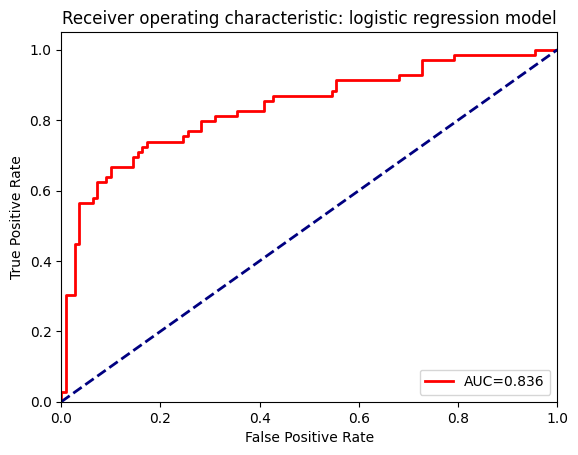

In [27]:
roc_auc = roc_auc_score(y_test, model_logreg.predict_proba(X_test)[:,1])
probs = model_logreg.predict_proba(X_test) 
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
fig, ax = plt.subplots()
lw = 2
ax.plot(
    fpr, tpr,
    lw=lw,
    label=f"AUC={roc_auc:.3f}",
    color="red",
)
ax.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic: logistic regression model")
plt.legend(loc="lower right")
plt.show()

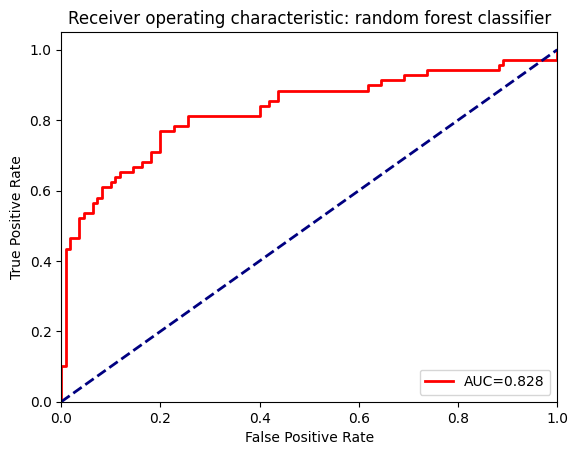

In [28]:
roc_auc = roc_auc_score(y_test, model_rfc.predict_proba(X_test)[:,1])
probs = model_rfc.predict_proba(X_test) 
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
fig, ax = plt.subplots()
lw = 2
ax.plot(
    fpr, tpr,
    lw=lw,
    label=f"AUC={roc_auc:.3f}",
    color="red",
)
ax.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic: random forest classifier")
plt.legend(loc="lower right")
plt.show()

The performance looks way better. However, maybe our sample due to the train-test split was particularly beneficial (or detrimental) for our analysis, so we should cross validate our model performance before drawing strong conclusions. Let's do that next.

In [29]:
# We should apply cross validation to our model
cv_splitter = StratifiedShuffleSplit(n_splits=10, random_state=42)
cross_val_log_reg = cross_val_score(estimator=model_logreg, X=df_to_analyze.drop(["Survived"], axis=1),y=df_to_analyze["Survived"],scoring='roc_auc', cv=cv_splitter, verbose=3)
cross_val_rfc = cross_val_score(estimator=model_rfc, X=df_to_analyze.drop(["Survived"], axis=1),y=df_to_analyze["Survived"],scoring='roc_auc', cv=cv_splitter, verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.849) total time=   0.0s
[CV] END ................................ score: (test=0.817) total time=   0.0s
[CV] END ................................ score: (test=0.782) total time=   0.0s
[CV] END ................................ score: (test=0.767) total time=   0.0s
[CV] END ................................ score: (test=0.888) total time=   0.0s
[CV] END ................................ score: (test=0.805) total time=   0.0s
[CV] END ................................ score: (test=0.833) total time=   0.0s
[CV] END ................................ score: (test=0.845) total time=   0.0s
[CV] END ................................ score: (test=0.819) total time=   0.0s
[CV] END ................................ score: (test=0.844) total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.855) total time=   0.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] END ................................ score: (test=0.809) total time=   0.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


[CV] END ................................ score: (test=0.764) total time=   0.7s
[CV] END ................................ score: (test=0.794) total time=   0.7s
[CV] END ................................ score: (test=0.892) total time=   0.8s
[CV] END ................................ score: (test=0.846) total time=   0.7s
[CV] END ................................ score: (test=0.902) total time=   0.7s
[CV] END ................................ score: (test=0.872) total time=   0.7s
[CV] END ................................ score: (test=0.848) total time=   0.7s
[CV] END ................................ score: (test=0.878) total time=   0.7s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.3s finished


In [30]:
print("Cross validated performance of the logistic regression on the training data: ", cross_val_log_reg.mean())
print("Cross validated performance of the random forest classifier on the training data: ", cross_val_rfc.mean())

Cross validated performance of the logistic regression on the training data:  0.8249090909090908
Cross validated performance of the random forest classifier on the training data:  0.8460000000000001


The results hold and actually improved a bit. It seems we've significantly improved the performance of our model on predicting likelihood of survival. Note, that since this is data from a Kaggle challenge, there is a separate test set for our model, so using the entire data set for cross-validation is not a problem here.
For our random forest classifier, we can now also easily extract a meaningful representation of feature importances:

<AxesSubplot: xlabel='Importance', ylabel='Feature name'>

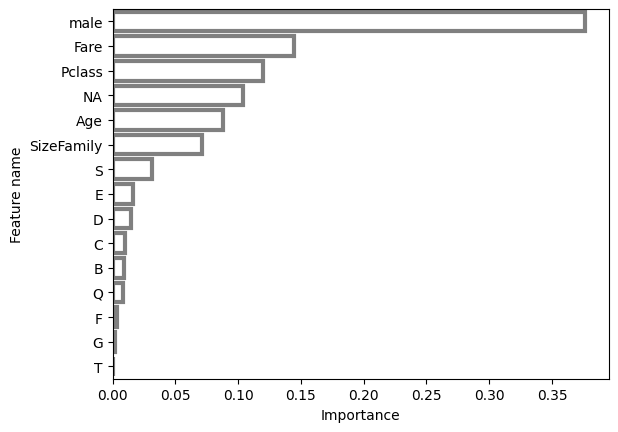

In [31]:
plot_importances = pd.DataFrame({"Importance": model_rfc.feature_importances_, "Feature name": model_rfc.feature_names_in_})
plot_importances = plot_importances.sort_values(by="Importance", ascending=False)
sns.barplot(y="Feature name", x="Importance", data=plot_importances, orient="h", errorbar=("pi", 50), capsize=.4, errcolor=".5",
    linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0))

We can infer from this plot, that the sex of the passenger is a strong predictor of survival, and to quite a lesser extent, fare and cabin class. Indeed, the majority of survivors were women. Additionally, there were also more survivors among the rich.